Created on December 20th 2020 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

# A few notebooks with various text mining and natural language processing experiments: Part 1

In the first part, we will be using spacy for tokenization, parsing and named entity recognition. We will then look at some simple statistics based on spacy results.

In [1]:
#check python version and path
import sys
sys.executable

'/Users/patrickrotzetter/opt/anaconda3/envs/spacy3x/bin/python'

In [2]:
#import main libraries
import numpy as np
import PyPDF2
import spacy
import pandas as pd
import re
from pptx import Presentation
import pdftotext
import texthero as hero

In [3]:
spacy.load('en_core_web_sm')

In [4]:
#  validate spacy language models just in case, this command does not work on Mac ARM systems unless you have installed the brew workaround and reinstalled python
!python3 -m spacy validate

/opt/homebrew/opt/python@3.9/bin/python3.9: No module named spacy


In [5]:
# function to read PDF files using PYPdf2
def readPdfFilePY(filename):
    text=""
    read_pdf = PyPDF2.PdfFileReader(filename,'rb')   
    for i in range(read_pdf.getNumPages()):
        page = read_pdf.getPage(i)
        txt=page.extractText()
        text=text+txt
    return text


In [6]:
# function to read PDF files using pdftotext
def readPdfFile(filename):
    text=""
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
        for page in pdf:
            text=text+page
    return text

In [7]:
# function to read PPT files
def readPPTFile(filename):
    text=""  
    prs = Presentation(filename)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text=text+shape.text
    text=remove_special_characters(text)
    return text

In [8]:
#path of first input test file
path='./sampledocs/pdf/'
docFile = path+'Technology-and-innovation-in-the-insurance-sector.pdf' 

In [9]:
#read the PDF File
 
textFromPdf=readPdfFile(docFile)
len(textFromPdf)

114110

In [10]:
# print the start of file to check we have read it correctly
print(textFromPdf[0:100])

Technology and
innovation in the
insurance sector

TECHNOLOGY AND INNOVATION
IN THE INSURANCE SECT


In [11]:
#path of second input file
docFile = path+'Digital-disruption-in-Insurance.pdf' 

In [12]:
#read the second PDF file   
textFromPdf2=readPdfFile(docFile)
len(textFromPdf2)

221719

In [13]:
# print the file to check we have read it correctly
print(textFromPdf2[0:100])

Digital disruption
in insurance:
Cutting through
the noise

Contents
Preface								

Facing digita


## Process files with spacy and calculate their similarity

In [14]:
# load spacy with large English model
# nlp = spacy.load("en-core-web-lg") -- was working on Windows, but now on a Mac
import en_core_web_lg
nlp = en_core_web_lg.load()

In [15]:
# let us process the 2 files using spacy pipeline
docpdf1=nlp(textFromPdf)
docpdf2=nlp(textFromPdf2)

In [16]:
# let us check the document vector shape
docpdf1.vector.shape

(96,)

In [17]:
# calculate document similarity with spacy function
docpdf1.similarity(docpdf2)

0.9627135828301324

In [18]:
# document similarity can also be calculated by multiplying the document vectors. we will use this later on
np.dot(docpdf1.vector,docpdf2.vector)

3.5181236

## Process all directory files with spacy

In [19]:
# helper function to process documents in an apply function and return the nlp object
def processDoc(doc):
    return nlp(doc)

In [20]:
# let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.pdf')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    fileText=readPdfFile(file_name)
    docName.append(file_name)
    docType.append('pdf')
    docText.append(fileText)
list_of_files = glob.glob(path+'*.pptx')           # create the list of file
for file_name in list_of_files:
    fileText=readPPTFile(file_name)
    docName.append(file_name)
    docType.append('ppt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])
fullDocs['NLP']=fullDocs['cleanText'].apply(processDoc)

In [21]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:87030.23809523809
Min length of text:9170
Max length of text:328295


In [22]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,NLP,text_word_count,text_unique_words
0,./sampledocs/pdf/ai_in_insurance_web_0.pdf,pdf,Promoting Responsible\nArtificial Intelligence...,promoting responsible artificial intelligence ...,"(promoting, responsible, artificial, intellige...",9087,2706
1,./sampledocs/pdf/NIST.IR.8312.pdf,pdf,NISTIR 8312\n\nFour Principles of Explainable ...,nistir four principles explainable artificial ...,"(nistir, four, principles, explainable, artifi...",16792,5026
2,./sampledocs/pdf/ai-360-research.pdf,pdf,AI 360: insights from the\nnext frontier of bu...,ai insights next frontier business corner offi...,"(ai, insights, next, frontier, business, corne...",5281,1746
3,./sampledocs/pdf/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,"(application, ai, insurtech, real, estate, tec...",3728,1506
4,./sampledocs/pdf/Technology-and-innovation-in-...,pdf,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,"(technology, innovation, insurance, sector, te...",16742,4228


In [23]:
fullDocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               21 non-null     object
 1   Type               21 non-null     object
 2   Text               21 non-null     object
 3   cleanText          21 non-null     object
 4   NLP                21 non-null     object
 5   text_word_count    21 non-null     int64 
 6   text_unique_words  21 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 1.3+ KB


In [24]:
fullDocs.describe()

,text_word_count,text_unique_words
count,21.000000,21.000000
mean,12911.190476,3385.523810
std,11605.351199,2097.456284
min,1454.000000,684.000000
25%,4424.000000,1746.000000
50%,10301.000000,2941.000000
75%,16742.000000,4329.000000
max,49748.000000,8458.000000


## Word count and most common words and nouns

In [25]:
# let us look most used words for each part of speech
from collections import defaultdict, Counter

posCounts = defaultdict(Counter)

for doc in fullDocs.NLP:
    for token in doc:
        posCounts[token.pos][token.orth] += 1

for pos_id, counts in sorted(posCounts.items()):
    pos = doc.vocab.strings[pos_id]
    for orth_id, count in counts.most_common(1):
        print(pos, count, doc.vocab.strings[orth_id])

ADJ 575 new
ADP 1689 ai
ADV 573 also
AUX 438 may
CCONJ 75 yet
DET 118 another
INTJ 124 ml
NOUN 1750 data
NUM 413 one
PART 855 '
PRON 64 fra
PROPN 975 data
PUNCT 1294 "
SCONJ 127 whether
SYM 12 *
VERB 580 based
X 50 etc


In [26]:
# add some common words to stop wordds that may not add much context
from spacy.lang.en.stop_words import STOP_WORDS
customStopWords = [
    'insurance','insurer','customer','technology','datum']

for w in customStopWords:
    if w not in STOP_WORDS:
        STOP_WORDS.add(w)

In [27]:
# get most common nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    words += [token.lemma_ for token in doc if token.pos==NOUN and (not token.lemma_ in STOP_WORDS)] 
# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
print(commonWords)

[('use', 860), ('risk', 779), ('system', 729), ('intelligence', 562), ('decision', 559), ('company', 532), ('business', 528), ('example', 524), ('product', 517), ('service', 487), ('right', 483), ('information', 452), ('consumer', 449), ('process', 429), ('claim', 397), ('case', 391), ('impact', 368), ('time', 360), ('explanation', 349), ('market', 340)]


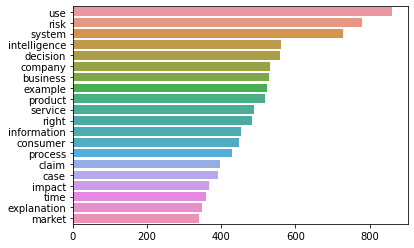

In [28]:
import seaborn as sns
%matplotlib inline

def displayEntitiesChart(commonEntities,n=20, save=False, saveToFile='test.jpg'):
    x, y= [], []
    for word,count in commonEntities[:n]:
            x.append(word)
            y.append(count)
        
    plot= sns.barplot(x=y,y=x)
    fig = plot.get_figure()
    if save:
        fig.savefig(saveToFile)
displayEntitiesChart(commonWords)

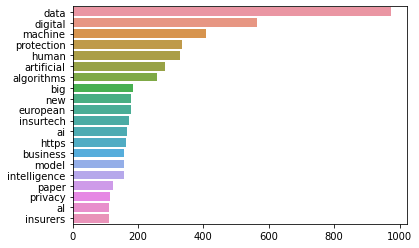

In [29]:
# get most common proper nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    
    words += [token.lemma_ for token in doc if token.pos==PROPN and (not token.lemma_ in STOP_WORDS)\
             and (len(token)>1)] 


# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
displayEntitiesChart(commonWords)

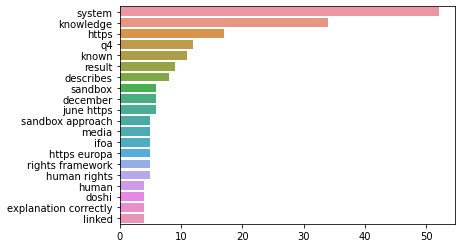

In [30]:
# most frequest PERSON entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'PERSON':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities)

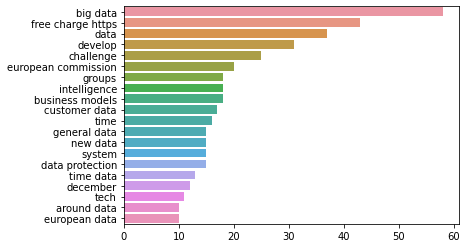

In [31]:
# most frequest ORG entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'ORG':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities,20,True,'spacy23.jpg')